In [ ]:
!if [ -d HSE ]; then rm -Rf HSE; fi
!git clone https://github.com/Tikhon239/HSE
!cp -a /content/HSE/BayesML/DDPM/* .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip3 install wandb
!pip3 install ml_collections
!pip3 install skimage
!pip3 install pytorch_fid

In [1]:
import torch
import numpy as np
import os

from skimage.io import imread, imsave
from tqdm.auto import trange, tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Resize
from pytorch_fid import fid_score

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Определим папку с настоящими картинками

In [3]:
def create_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
TOTAL_IMAGES_COUNT = 20_000
BATCH_SIZE = 200
NUM_ITERS = TOTAL_IMAGES_COUNT // BATCH_SIZE

device = torch.device('cuda')

In [5]:
create_dir('./real_images_MNIST')

real_dataset = MNIST(root='./data', download=True, train=True, transform=Compose([Resize((32, 32))]))
for idx, (image_mnist, label) in enumerate(tqdm(real_dataset, total=TOTAL_IMAGES_COUNT)):
    if idx == TOTAL_IMAGES_COUNT:
        break
    image = np.array(image_mnist)
    imsave("./real_images_MNIST/{}.png".format(idx), image)

  0%|          | 0/20000 [00:00<?, ?it/s]

#### Определим папку для синтетических картинок и сгенерируем 60к картинок

In [6]:
uncond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)
uncond_diff.model.eval();

In [7]:
create_dir('./uncond_mnist')

global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = uncond_diff.sample_images(batch_size=BATCH_SIZE).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('./uncond_mnist', f'{global_idx}.png'), images[i])
        global_idx += 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['./real_images_MNIST', './uncond_mnist'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


116.63311799845394

In [9]:
cond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)
cond_diff.model.eval()

classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./drive/MyDrive/ddpm_checkpoints/classifier.pth'))

cond_diff.set_classifier(noisy_classifier, 1.0)

In [ ]:
create_dir('./cond_mnist')

labels = torch.arange(10, device=device).repeat(BATCH_SIZE // 10)

global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = cond_diff.sample_images(batch_size=BATCH_SIZE, labels=labels).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('./cond_mnist', f'{global_idx}.png'), images[i])
        global_idx += 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [1]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['./real_images_MNIST', './cond_mnist'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

152.50308523976827

Посчитал в другом ноутбуке
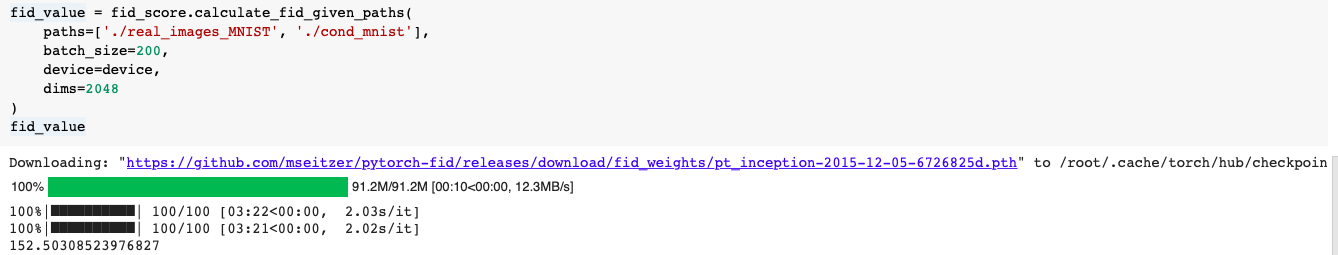

> Какой фид получился? Сравните FID для безусловной генерации и для условной. Сгенерируйте для каждого класса по 6к картинок и посчитайте FID между реальными и условно сгенерированными картинками.

FID очень большой при адекватных семплах, наверное 5к степов на обучение маловато.

FID для безусловной генерации ниже, чем для условной. Может быть было бы лучше параллельно учить классификатор и модель, чтобы не было различий в FID.